In [ ]:
from sys import path
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import logging
logging.getLogger("pypsa").setLevel(logging.ERROR)

BASE_DIR = Path.cwd()
path.append(str(BASE_DIR.parent))

from custom_package.Plot_Helper_funcs import *
from custom_package.Class_funcs import *

data_file = BASE_DIR / "Timeseries_3.156_101.691_E5_1kWp_crystSi_14_0deg_-1deg_2023_2023.csv"

In [ ]:
arr = np.loadtxt(data_file, 
                 delimiter=',', 
                 skiprows=23, 
                 usecols=(1))

solar_profile = np.concatenate((np.zeros(8), arr[:-8]))/1000
solar_profile *= 1500/np.sum(solar_profile) # Scale to 1.5 MWh/year

config = {#Sen/kWh
    # "snapshots": range(len(solar_profile)),
    "holiday_arr": [0, 28, 29, 89, 90, 120, 131, 152, 157, 177, 242, 248, 257, 292, 357], # based on 2025, https://www.mytnb.com.my/tariff/index.html?v=1.1.47#faq
    "peak_hours": np.arange(13,22), # 2pm to 10pm
    "peak_profile_simplistic": False,
    "peak_profile": None, # Optional
    "grid_import_profile": np.array((np.arange(len(solar_profile)) % 24) < 8, dtype=int),
	"solar_profile": solar_profile,
    "kW_solar": 3, # kW
    "battery_efficiency": 0.9,
    "BESS_capacity": 8,
}

config["finanicials"] = {"wheeling_charge": 20, # sen/kWh
                         "electricity_price_grid": 0, # sen/kWh, already included in peak and off-peak charge
							"capacity_charge": 21.76*100, # sen/kW/month,
							"network_charge": 23.06*100, # sen/kW/month,
							"off_peak_charge": 51.09,
							"peak_charge": 55.18,
                            "peak_charge_plus": 18,
							"green_electricity_tariff": 5.0,
						 	"PV_per_kWp": 180, # MYR per kWp
                            "BESS_per_kWh": 48, # MYR per kWh
							"grid_charging_tariff": 60, # sen/kWh, IN TOTAL: inbetween 
                            "peak_quadratic_cost": 10
						 }


1500.0


<>:1: DeprecationWarning: invalid escape sequence '\D'
<>:1: DeprecationWarning: invalid escape sequence '\D'
C:\Users\royro\AppData\Local\Temp\ipykernel_7044\2569079559.py:1: DeprecationWarning: invalid escape sequence '\D'
  arr = np.loadtxt('C:\\Users\\royro\Desktop\\Solar_PPAs\\Timeseries_3.156_101.691_E5_1kWp_crystSi_14_0deg_-1deg_2023_2023.csv',


In [3]:
solar_arr = np.arange(1, 7.5, 0.5) # kWp
BESS_arr = np.arange(0, 17, 2) # kWh

result_arr = np.zeros((len(solar_arr), len(BESS_arr)))
CRESS_arr = array = [[0 for _ in range(len(BESS_arr))] for _ in range(len(solar_arr))]
for i, solar_kW in enumerate(solar_arr):
	for j, BESS_kWh in enumerate(BESS_arr):
		config["kW_solar"] = solar_kW
		config["BESS_capacity"] = BESS_kWh

		CRESS = CRESS_network("no_grid_charging", config, label=f"CRESS with no Grid Charging, {config['kW_solar']}kW solar, {config['BESS_capacity']}kWh BESS")

		CRESS.initialize_network()

		CRESS.n.optimize(
			solver_name="highs",
			log_to_console=False,
			solver_options={
				"solver": "ipm",
				"presolve": "on",          # default, but make explicit
				"parallel": "on",
				"threads": 8,              # match your CPU cores
				"time_limit": 3600,        # seconds   
			}
		)
		total_cost = CRESS.monthly_matching_costs(optimize=False)
		CRESS.gather_statistics()
		print(i, j, total_cost)
		result_arr[i, j] = total_cost
		CRESS_arr[i][j] = CRESS




C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: invalid value encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)


peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 85.70it/s]
INFO:linopy.io: Writing time: 1.36s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal

C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)


CRESS kWh per year 1487.109906952116
2241.0
0 0 5125.46013938664
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 81.25it/s]
INFO:linopy.io: Writing time: 1.55s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal

C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)


CRESS kWh per year 1487.109906952116
2241.0
0 1 5221.46013938664
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 54.00it/s]
INFO:linopy.io: Writing time: 1.5s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 1487.109906952116
2241.0
0 2 5317.46013938664
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 77.19it/s]
INFO:linopy.io: Writing time: 1.47s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 1487.109906952116
2241.0
0 3 5413.46013938664
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 48.16it/s]
INFO:linopy.io: Writing time: 2.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 1487.109906952116
2241.0
0 4 5509.46013938664
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.87it/s]
INFO:linopy.io: Writing time: 1.92s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 1487.109906952116
2241.0
0 5 5605.46013938664
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 64.90it/s]
INFO:linopy.io: Writing time: 1.92s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 1487.109906952116
2241.0
0 6 5701.46013938664
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.50it/s]
INFO:linopy.io: Writing time: 1.88s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 1487.109906952116
2241.0
0 7 5797.46013938664
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 61.30it/s]
INFO:linopy.io: Writing time: 1.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 1487.109906952116
2241.0
0 8 5893.46013938664
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.43it/s]
INFO:linopy.io: Writing time: 1.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.00e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2208.545418479055
2241.0
1 0 4925.587350855117
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 48.09it/s]
INFO:linopy.io: Writing time: 2.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.93e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2218.4479168399207
2241.0
1 1 5017.608527013721
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 56.49it/s]
INFO:linopy.io: Writing time: 2.12s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.91e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2207.7768284824574
2241.0
1 2 5117.896170315748
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 56.60it/s]
INFO:linopy.io: Writing time: 1.99s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.91e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2201.898751367687
2241.0
1 3 5216.257981700464
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 51.97it/s]
INFO:linopy.io: Writing time: 2.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2200.868847657787
2241.0
1 4 5312.671797011102
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 59.30it/s]
INFO:linopy.io: Writing time: 2.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2200.549831811365
2241.0
1 5 5408.799977578194
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 65.23it/s]
INFO:linopy.io: Writing time: 1.95s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2200.463895175864
2241.0
1 6 5504.834506918338
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 57.53it/s]
INFO:linopy.io: Writing time: 2.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2200.463895175864
2241.0
1 7 5600.834506918338
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.16it/s]
INFO:linopy.io: Writing time: 1.94s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2200.463895175864
2241.0
1 8 5696.834506918338
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 59.37it/s]
INFO:linopy.io: Writing time: 1.94s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.70e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2681.7061829974186
2241.0
2 0 4843.496238556231
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.03it/s]
INFO:linopy.io: Writing time: 2.1s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.45e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2940.0764275108604
2241.0
2 1 4846.250417311331
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.22it/s]
INFO:linopy.io: Writing time: 2.0s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.42e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2928.2203360281696
2241.0
2 2 4946.5292807274345
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 61.70it/s]
INFO:linopy.io: Writing time: 2.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.40e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2918.336696529376
2241.0
2 3 5046.09628622255
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.77it/s]
INFO:linopy.io: Writing time: 2.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.39e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2908.889381852854
2241.0
2 4 5145.505822089305
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 54.02it/s]
INFO:linopy.io: Writing time: 1.85s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.38e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2900.841314781287
2241.0
2 5 5244.410369495434
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 50.59it/s]
INFO:linopy.io: Writing time: 2.14s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.37e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2896.0592858032564
2241.0
2 6 5342.1362037536055
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.16it/s]
INFO:linopy.io: Writing time: 1.98s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.37e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2894.304686505274
2241.0
2 7 5438.769438640247
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 52.00it/s]
INFO:linopy.io: Writing time: 2.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.37e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2893.5383504745055
2241.0
2 8 5535.046009313751
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.50it/s]
INFO:linopy.io: Writing time: 2.31s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.52e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 2952.7583980675504
2241.0
3 0 4835.673494137422
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 51.76it/s]
INFO:linopy.io: Writing time: 2.12s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.12e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3483.7635923111498
2241.0
3 1 4740.033719534906
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.41it/s]
INFO:linopy.io: Writing time: 2.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.95e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3631.7512363820433
2241.0
3 2 4782.62497878972
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 44.15it/s]
INFO:linopy.io: Writing time: 2.27s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.93e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3631.8148919190644
2241.0
3 3 4878.60200550641
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 51.44it/s]
INFO:linopy.io: Writing time: 2.34s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.91e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3629.0636508753996
2241.0
3 4 4975.594928399069
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.80it/s]
INFO:linopy.io: Writing time: 2.15s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.90e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3625.377470044832
2241.0
3 5 5072.92527106082
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.58it/s]
INFO:linopy.io: Writing time: 2.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.90e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3622.556669651056
2241.0
3 6 5169.943297922935
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.40it/s]
INFO:linopy.io: Writing time: 2.32s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.89e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3620.726835912515
2241.0
3 7 5266.603684919173
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 65.76it/s]
INFO:linopy.io: Writing time: 2.21s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.89e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3619.669795991585
2241.0
3 8 5362.985170626637
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 62.25it/s]
INFO:linopy.io: Writing time: 1.98s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.41e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3129.5413325202544
2241.0
4 0 4861.87253309344
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 67.35it/s]
INFO:linopy.io: Writing time: 1.85s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.95e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3756.960132779589
2241.0
4 1 4731.437088079847
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.81it/s]
INFO:linopy.io: Writing time: 2.21s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.62e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4178.0660066615965
2241.0
4 2 4675.45997819583
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.62it/s]
INFO:linopy.io: Writing time: 2.17s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.50e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4328.2294912806865
2241.0
4 3 4717.265976596801
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 44.40it/s]
INFO:linopy.io: Writing time: 2.17s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.49e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4343.399297793367
2241.0
4 4 4807.791193426374
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 52.50it/s]
INFO:linopy.io: Writing time: 2.12s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.48e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4345.527709280772
2241.0
4 5 4903.023049720569
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 71.24it/s]
INFO:linopy.io: Writing time: 1.86s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.48e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4346.997653850198
2241.0
4 6 4998.492546725464
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 54.67it/s]
INFO:linopy.io: Writing time: 1.81s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.48e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4347.985341947293
2241.0
4 7 5094.136090091222
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 59.21it/s]
INFO:linopy.io: Writing time: 1.9s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.47e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4348.691727395926
2241.0
4 8 5189.881155582811
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 51.02it/s]
INFO:linopy.io: Writing time: 1.99s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.33e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3257.1768621484603
2241.0
5 0 4905.808870450621
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 68.60it/s]
INFO:linopy.io: Writing time: 1.74s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.85e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3914.783315927271
2241.0
5 1 4764.478701281849
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 62.32it/s]
INFO:linopy.io: Writing time: 2.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.44e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4473.239295595327
2241.0
5 2 4658.931938219646
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 62.59it/s]
INFO:linopy.io: Writing time: 1.85s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.19e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4858.594954997523
2241.0
5 3 4615.857080741394
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 65.04it/s]
INFO:linopy.io: Writing time: 1.8s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.10e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5021.472063027697
2241.0
5 4 4653.074732453304
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 62.67it/s]
INFO:linopy.io: Writing time: 2.24s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.08e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5045.813070909314
2241.0
5 5 4740.290062708829
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 63.64it/s]
INFO:linopy.io: Writing time: 1.93s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.08e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5047.42783817576
2241.0
5 6 4835.707293202368
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 67.37it/s]
INFO:linopy.io: Writing time: 1.88s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.08e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5048.376774731469
2241.0
5 7 4931.364821999414
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 65.17it/s]
INFO:linopy.io: Writing time: 1.81s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.08e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5048.989866515544
2241.0
5 8 5027.143557174541
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 59.03it/s]
INFO:linopy.io: Writing time: 2.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.26e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3354.5503769261672
2241.0
6 0 4960.666768967348
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 62.08it/s]
INFO:linopy.io: Writing time: 1.96s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.78e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4023.7993463584758
2241.0
6 1 4815.134815899227
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 66.65it/s]
INFO:linopy.io: Writing time: 1.75s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.34e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4641.705202699514
2241.0
6 2 4688.132592345746
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 49.37it/s]
INFO:linopy.io: Writing time: 2.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.02e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5166.551463838579
2241.0
6 3 4594.715576700657
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 66.84it/s]
INFO:linopy.io: Writing time: 1.91s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.81e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5530.056098774923
2241.0
6 4 4559.52675395213
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.27it/s]
INFO:linopy.io: Writing time: 2.14s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.72e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5698.850625489517
2241.0
6 5 4594.608809260833
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 54.13it/s]
INFO:linopy.io: Writing time: 2.75s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.70e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5733.521716632286
2241.0
6 6 4678.0960124674075
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 49.03it/s]
INFO:linopy.io: Writing time: 2.55s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.70e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5735.604027868728
2241.0
6 7 4773.344506342177
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 51.68it/s]
INFO:linopy.io: Writing time: 2.27s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.70e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5735.756845856782
2241.0
6 8 4869.289354330288
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 54.70it/s]
INFO:linopy.io: Writing time: 2.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.22e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3430.3176255513804
2241.0
7 0 5023.322368938507
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 50.96it/s]
INFO:linopy.io: Writing time: 1.91s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.73e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4107.790449134099
2241.0
7 1 4874.822426907504
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 61.99it/s]
INFO:linopy.io: Writing time: 1.92s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.27e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4750.916608574979
2241.0
7 2 4738.71819596529
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 59.23it/s]
INFO:linopy.io: Writing time: 1.97s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.92e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5346.166167526217
2241.0
7 3 4619.892630139789
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.77it/s]
INFO:linopy.io: Writing time: 2.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.64e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5842.441828570859
2241.0
7 4 4536.786744068777
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.74it/s]
INFO:linopy.io: Writing time: 2.45s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.44e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6187.191349336362
2241.0
7 5 4508.366642024507
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 46.44it/s]
INFO:linopy.io: Writing time: 2.44s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.34e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6365.116303089633
2241.0
7 6 4540.153526214952
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.19it/s]
INFO:linopy.io: Writing time: 2.64s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.32e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6412.613177623258
2241.0
7 7 4619.011904195766
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.09it/s]
INFO:linopy.io: Writing time: 2.22s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.31e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6418.039711437837
2241.0
7 8 4713.053468142085
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 49.56it/s]
INFO:linopy.io: Writing time: 2.61s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.18e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3491.5207311209324
2241.0
8 0 5091.234168138456
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 45.59it/s]
INFO:linopy.io: Writing time: 2.72s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.69e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4173.728828904442
2241.0
8 1 4941.025265648387
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 52.62it/s]
INFO:linopy.io: Writing time: 2.68s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.22e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4830.2997735379995
2241.0
8 2 4800.068811730136
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 65.62it/s]
INFO:linopy.io: Writing time: 2.22s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.85e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5458.219647018434
2241.0
8 3 4669.452529391047
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 62.15it/s]
INFO:linopy.io: Writing time: 2.43s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.53e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6031.258527945303
2241.0
8 4 4558.64279726454
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 63.33it/s]
INFO:linopy.io: Writing time: 1.97s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.27e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6504.110401479151
2241.0
8 5 4483.990556106174
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 59.69it/s]
INFO:linopy.io: Writing time: 2.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.08e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6837.763670306217
2241.0
8 6 4459.575091386487
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 68.32it/s]
INFO:linopy.io: Writing time: 2.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 9.73e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7025.13276914243
2241.0
8 7 4487.953583616498
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 67.85it/s]
INFO:linopy.io: Writing time: 1.99s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 9.46e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7072.946717734058
2241.0
8 8 4566.697529569778
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.85it/s]
INFO:linopy.io: Writing time: 2.47s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.14e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3543.250153674988
2241.0
9 0 5162.565019538697
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.56it/s]
INFO:linopy.io: Writing time: 2.34s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.66e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4228.531992907502
2241.0
9 1 5011.246803759683
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 45.74it/s]
INFO:linopy.io: Writing time: 2.45s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.18e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4895.286026736684
2241.0
9 2 4866.615272950731
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 40.12it/s]
INFO:linopy.io: Writing time: 2.71s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.81e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5540.354584404726
2241.0
9 3 4729.810030488335
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 43.00it/s]
INFO:linopy.io: Writing time: 2.7s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.46e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6149.5990739497975
2241.0
9 4 4605.933694211519
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 40.45it/s]
INFO:linopy.io: Writing time: 2.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.15e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6701.162936276931
2241.0
9 5 4502.874296297656
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.81it/s]
INFO:linopy.io: Writing time: 2.48s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 9.00e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7155.832708358049
2241.0
9 6 4434.783975553581
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 26.85it/s]
INFO:linopy.io: Writing time: 2.55s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 7.16e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7483.34999369313
2241.0
9 7 4412.58298727615
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.81it/s]
INFO:linopy.io: Writing time: 2.79s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 6.57e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7588.723983169083
2241.0
9 8 4470.553514474278
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 39.46it/s]
INFO:linopy.io: Writing time: 2.76s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.12e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3587.2497060784144
2241.0
10 0 5236.685581076301
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 48.86it/s]
INFO:linopy.io: Writing time: 2.65s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.63e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4275.1205521359625
2241.0
10 1 5084.432992734132
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 37.97it/s]
INFO:linopy.io: Writing time: 2.98s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.15e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4947.543701779563
2241.0
10 2 4937.755478027756
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 37.96it/s]
INFO:linopy.io: Writing time: 2.86s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.77e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5603.428089256742
2241.0
10 3 4797.0468025872415
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 35.92it/s]
INFO:linopy.io: Writing time: 2.78s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.42e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6235.565265497566
2241.0
10 4 4664.908495681929
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 23.22it/s]
INFO:linopy.io: Writing time: 4.14s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.08e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6828.724260455814
2241.0
10 5 4546.837414401497
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 40.01it/s]
INFO:linopy.io: Writing time: 2.88s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 7.84e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7362.397719811101
2241.0
10 6 4450.234662920174
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 37.25it/s]
INFO:linopy.io: Writing time: 2.71s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 5.37e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7801.910831346402
2241.0
10 7 4387.614380967084
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.61it/s]
INFO:linopy.io: Writing time: 2.73s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.54e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7950.689954107363
2241.0
10 8 4429.919995562654
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.70it/s]
INFO:linopy.io: Writing time: 2.75s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.09e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3624.780672810842
2241.0
11 0 5313.140655182568
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 37.54it/s]
INFO:linopy.io: Writing time: 2.96s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.60e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4314.52405616115
2241.0
11 1 5160.212268131441
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 52.81it/s]
INFO:linopy.io: Writing time: 2.93s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.12e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4990.635120486238
2241.0
11 2 5012.203785016517
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 52.57it/s]
INFO:linopy.io: Writing time: 2.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.74e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5655.599765844172
2241.0
11 3 4868.218044506839
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 36.63it/s]
INFO:linopy.io: Writing time: 3.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.38e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6300.834941411771
2241.0
11 4 4731.3526696444915
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 39.99it/s]
INFO:linopy.io: Writing time: 2.97s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.03e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6918.255273392128
2241.0
11 5 4604.525671832781
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 37.96it/s]
INFO:linopy.io: Writing time: 3.21s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 7.08e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7498.509889375879
2241.0
11 6 4491.111780924245
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 42.33it/s]
INFO:linopy.io: Writing time: 3.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.17e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 8016.557442071769
2241.0
11 7 4400.148419156298
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 30.88it/s]
INFO:linopy.io: Writing time: 2.97s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.18e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 8193.24867165037
2241.0
11 8 4432.380554401382
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 36.80it/s]
INFO:linopy.io: Writing time: 3.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.07e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 3657.4788832846607
2241.0
12 0 5391.3398710225665
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 39.97it/s]
INFO:linopy.io: Writing time: 3.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.58e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 4348.515887726423
2241.0
12 1 5237.944616119535
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 54.01it/s]
INFO:linopy.io: Writing time: 3.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.10e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5027.438454419367
2241.0
12 2 5088.921461800051
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.72it/s]
INFO:linopy.io: Writing time: 2.66s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.72e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 5698.3748157963455
2241.0
12 3 4942.7805289790995
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 34.29it/s]
INFO:linopy.io: Writing time: 4.0s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.35e+05
Solver model: available
Solver message: Optimal



CRESS kWh per year 6352.813510642214
2241.0
12 4 4802.593604009225
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 38.18it/s]
INFO:linopy.io: Writing time: 3.72s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 9.93e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 6988.741960327618
2241.0
12 5 4669.087026517764
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 40.44it/s]
INFO:linopy.io: Writing time: 3.16s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 6.54e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 7593.186412214989
2241.0
12 6 4546.943023831611
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 45.88it/s]
INFO:linopy.io: Writing time: 2.87s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.36e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 8161.19155200765
2241.0
12 7 4437.949968880439
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 41.75it/s]
INFO:linopy.io: Writing time: 3.44s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.33e+04
Solver model: available
Solver message: Optimal



CRESS kWh per year 8344.563809272873
2241.0
12 8 4467.77092123342


97
Optimal config: 6.0 kWp solar, 14 kWh BESS, cost: 4387.614380967084 RM/year
Optimal config: 3.0 kWp solar, 6 kWh BESS, cost: 4717.265976596801 RM/year


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Plot_Helper_funcs.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\royro\AppData\Local\Temp\ipykernel_7044\2869599093.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


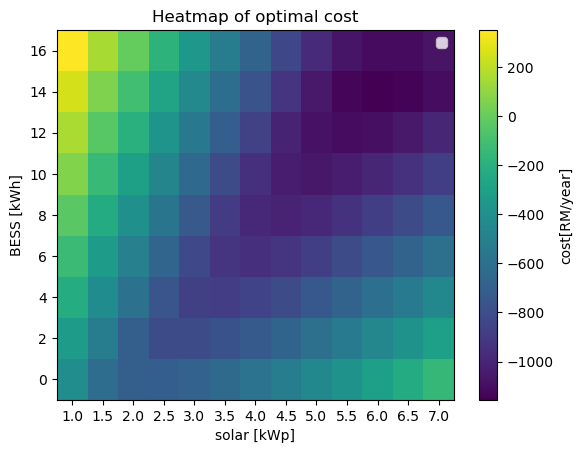

In [ ]:
produce_heatmap(result_arr, solar_arr, BESS_arr, x_label='solar [kWp]', y_label='BESS [kWh]', z_label='cost[RM/year]', title_str='Heatmap of optimal cost')

a = np.argmin(np.array(result_arr))
print(a)
i_opt, j_opt = np.unravel_index(a, result_arr.shape)
print(f"Optimal config: {solar_arr[i_opt]} kWp solar, {BESS_arr[j_opt]} kWh BESS, cost: {result_arr[i_opt, j_opt]} RM/year")

plt.legend()
plt.show()

curtailment 6.466103831094652 %
grid usage 10.937090966365266 %


(array([<Axes: title={'center': 'average day of: CRESS with no Grid Charging, 6.0kW solar, 14kWh BESS'}, ylabel='Power (kW)'>,
        <Axes: xlabel='Hour of the day', ylabel='Battery Charge (kWh)'>],
       dtype=object),
 <Figure size 1200x800 with 2 Axes>)

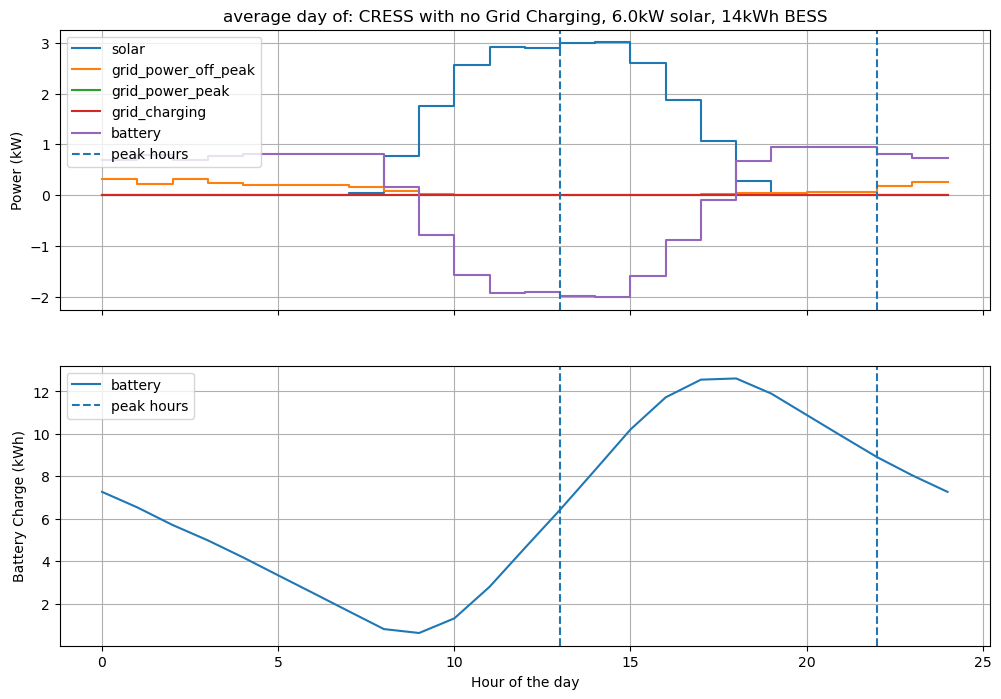

In [ ]:
CRESS_opt = CRESS_arr[i_opt][j_opt]

print("curtailment", CRESS_opt.stats["solar_curtailment"]/(np.sum(solar_profile)*config["kW_solar"])*100, "%")
print("grid usage", np.sum(CRESS_opt.n.generators_t.p['grid_power_peak'])+np.sum(CRESS_opt.n.generators_t.p['grid_power_off_peak'])/8760*100, "%")

CRESS_opt.plot_average_day()